In [21]:
!pip install opencv-contrib-python==4.4.0.44

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import randrange

In [23]:
from google.colab.patches import cv2_imshow

In [4]:
print (cv2 .__version__)

4.4.0


In [24]:
# read the images
img1 = cv2.imread('img1.png')  
img2 = cv2.imread('img2.png')

# convert images to grayscale
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
# create SIFT object
#sift = cv2.SIFT_create()
# detect SIFT features in both images
sift = cv2.xfeatures2d.SIFT_create()
feature_extractor = cv2.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

In [ ]:
#
# find the keypoints and descriptors with SIFT
#kp1, des1 = sift.detectAndCompute(img1,None)
#kp2, des2 = sift.detectAndCompute(img2,None)

In [25]:
# create feature matcher
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
# match descriptors of both images
matches = bf.match(descriptors_1,descriptors_2)

In [26]:
# sort matches by distance
matches = sorted(matches, key = lambda x:x.distance)

# draw first 50 matches
matched_img = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)

In [30]:
img1.shape

(360, 640)

In [27]:
# Initialize lists
list_kp1 = []
list_kp2 = []

# For each match...
for mat in matches:

    # Get the matching keypoints for each of the images
    img1_idx = mat.queryIdx
    img2_idx = mat.trainIdx

    # x - columns
    # y - rows
    # Get the coordinates
    (x1, y1) = keypoints_1[img1_idx].pt
    (x2, y2) = keypoints_2[img2_idx].pt

    # Append to each list
    list_kp1.append((x1, y1))
    list_kp2.append((x2, y2))

In [ ]:
list_kp1

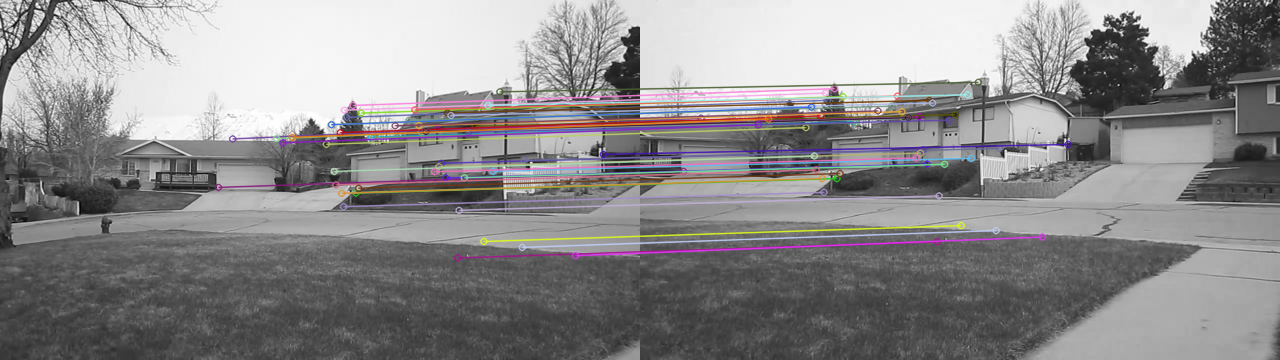

In [9]:
# show the image
cv2_imshow(matched_img)
# save the image
cv2.imwrite("matched_images.jpg", matched_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [11]:
# Apply ratio test
good = []
for m in matches:
  if m[0].distance < 0.5*m[1].distance:
    good.append(m)
    matches = np.asarray(good)
    if len(matches[:,0]) >= 4:
      src = np.float32([ keypoints_1[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
      dst = np.float32([ keypoints_2[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
      H, masked = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
      print (H)
  else:
    raise AssertionError("Can’t find enough keypoints.")
  

TypeError: ignored

In [ ]:
def bilinear_interpolate(zero_padded_source_image, x, y):
    # shape of the zero padded image
    dx, dy = np.shape(zero_padded_source_image)
    # get the shape of the original image
    dx, dy = dx-2, dy-2
    # +1 as we are taking coordinates with respect to a zero padded image
    x, y = x+1, y+1

    # x', y', a, b as defined in the lecture
    x_prime, y_prime = floor(x), floor(y)
    a = x-x_prime
    b = y-y_prime

    if x_prime >= 0 and x_prime <= dx and y_prime >= 0 and y_prime <= dy:
        # intensity value using bilinear interpolation
        intensity_val = (1-a)*(1-b)*zero_padded_source_image[x_prime, y_prime] \
            + (1-a)*b*zero_padded_source_image[x_prime, y_prime+1] \
            + a*(1-b)*zero_padded_source_image[x_prime+1, y_prime] \
            + a*b*zero_padded_source_image[x_prime+1, y_prime+1]
    else:
        # If the (xs, ys) does not exist in the source image, assign 0
        # for the corresponding (xt, yt) in the target image
        intensity_val = 0

    return intensity_val

In [ ]:
def A_matrix(points, corresponding_points):
    # Check that the number of points and their corresponding
    # points is equal
    assert len(points) == len(corresponding_points), "Mismatch in number of points"
    n_correspondances = len(points)
    # from each point correspondance we get two values
    A_mat = np.zeros((2*n_correspondances, 5))
    for i in range(n_correspondances):
        x, y = points[i]
        x_prime, y_prime = corresponding_points[i]
        # As defined above
        A_mat[2*i] = [x, y, 1, 0, -x_prime]
        A_mat[2*i+1] = [y, -x, 0, 1, -y_prime]
    return A_mat

In [ ]:
def compute_homography(A_matrix):
    # NumPy SVD gives singular values in decreasing order
    u, s, v_transpose = np.linalg.svd(A_matrix)
    # take the last row of v_transpose
    a, b, c, d, h = v_transpose[-1]
    # construct the appropriate 3x3 matrix
    H = np.array([[a, b, c], [-b, a, d], [0, 0, h]]).reshape(3,3)
    return H    

In [ ]:
def ransac(imgpts1,imgpts2,epsilon,consensusfraction,n_iteration):
  total_pts=len(imgpts1)
  consensus_set_min_pts=np.ceil(consensusfraction*total_pts)
  
  A=A_matrix(pts,correp_pts)
  H=compute_homography(A)
